In [1]:
from langdetect import detect
import re
from Scripts import loading as dl, profiling as pf, cleaning as cl
import matplotlib.pyplot as plt

In [2]:
# Input
db_path = '../Data/phonereviews.db'
db_name = 'phonereviews'
df = dl.load_from_db(db_path, db_name)

In [3]:
df.head()

,NODE,URL,REVIEWBODY,RATING,REVIEWRATING,BESTRATING,WORSTRATING
0,_:node89ce3018196554d41bceaeac30a31e,https://www.techworld.com/review/smartphones/l...,"""The smartphone market is as competitive as ev...",None,None,None,None
1,_:nodec8b9fba77ad36d9d11460c11f9151d9,https://www.technospain.es/fundas-smartphones-...,None,_:node46ac847e2080dc78cf9ae447647ac8d4,"""5""@es-es","""5""@es-es",None
2,_:node46ac847e2080dc78cf9ae447647ac8d4,https://www.technospain.es/fundas-smartphones-...,None,None,"""5""@es-es","""5""@es-es",None
3,_:nodef160bce2dcba31bd02d1a072e6ad2,https://www.technospain.es/fundas-smartphones-...,None,_:nodef4bf4b94afaabab1bbb342d3ccc284af,"""2""@es-es","""5""@es-es",None
4,_:nodef4bf4b94afaabab1bbb342d3ccc284af,https://www.technospain.es/fundas-smartphones-...,None,None,"""2""@es-es","""5""@es-es",None


In [4]:
total = len(df)
df.describe()

,NODE,URL,REVIEWBODY,RATING,REVIEWRATING,BESTRATING,WORSTRATING
count,809937,809937,316424,375232,735137,283704,190129
unique,809853,88282,73748,368907,2086,210,158
top,_:node554918d6506313e4bdb1ee68ed1341bc,https://my-phone-finder.com/find-imei,"""Cancel this order""",\n\n5 / 5,"""5""","""5""","""0"""
freq,2,3590,31383,2898,387649,66637,53927


In [5]:
# DATA COMPLETENESS
# Del incomplete entries based on missing values
print('Missing review data as percentage: {:.2%} '.format(len(df[df.REVIEWBODY.isnull()])/len(df)))
print('Missing rating information as percentage: {:.2%}'.format(len(df[df.REVIEWBODY.isnull()&df.RATING.isnull()&df.REVIEWRATING.isnull()&df.BESTRATING.isnull()&df.WORSTRATING.isnull()])/total))
df = df[df.REVIEWBODY.notnull()&df.RATING.notnull()&df.REVIEWRATING.notnull()&df.BESTRATING.notnull()&df.WORSTRATING.notnull()]
print("After removing missing text and ratings: ", len(df))

Missing review data as percentage: 60.93% 
Missing rating information as percentage: 3.10%
After removing missing text and ratings:  45696


In [6]:
# Del incomplete entries based on implictly missing values
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)
def checkmisrat(row):
    result = hasNumbers(row['REVIEWRATING']) and hasNumbers(row['BESTRATING']) and hasNumbers(row['WORSTRATING'])
    return result
df['mis_rat'] = df.apply(checkmisrat, axis=1)
print('Implicitly missing rating data as percentage: {:.2%} '.format((len(df[df['mis_rat']==False]))/total))
df = df[df['mis_rat']==True]
print("After removing implictly missing rating information: ", len(df))

Implicitly missing rating data as percentage: 0.19% 
After removing implictly missing rating information:  44124


In [7]:
# Generally del missing values (should not change much by now)
df.dropna()
len(df)

44124

In [8]:
# DUPLICATION DELETION

df_dup = df[df.duplicated(subset=['REVIEWBODY','REVIEWRATING'], keep='last')]
df_dup2 = df[df.duplicated(subset=['REVIEWBODY'], keep='last')]
print("Duplicate text and label from reviews without missing information: {:.2%}".format(len(df_dup)/ len(df)))
print("Duplicate text: {:.2%}".format(len(df_dup2)/ len(df)))

df= df.drop_duplicates(subset=['REVIEWBODY','REVIEWRATING'], keep='last')
df = df.drop_duplicates(subset=['REVIEWBODY'], keep='last')
print("After removing duplicate entries and texts: ", len(df))

Duplicate text and label from reviews without missing information: 43.57%
Duplicate text: 43.68%
After removing duplicate entries and texts:  24850


In [9]:
# DOMAIN OR OTHER HEURISTICS - only applied to schema - cellphones and accessories
# johnpacker - musical instrument shop
df = df[~df['URL'].str.contains("johnpacker")]
df = df[~df['REVIEWBODY'].str.contains("saxophone")] #14 entries
# Remove entries from unwanted domains connected to phone
df = df[~(df['URL'].str.contains('repair'))]   #1641
df = df[~(df['URL'].str.contains('travel'))]   #31
df = df[~(df['URL'].str.contains('clinic'))]   #2
df = df[~(df['URL'].str.contains('service'))]  #20
print("After removing other related mistakes: ", len(df))



After removing other related mistakes:  23113


In [ ]:
# NON-ENGLISH TEXT DELETION
def detectLang(row):
    try:
        return detect(row['REVIEWBODY'])
    except:
        print("exception:", row['REVIEWBODY'])
    else:
        print("sad:", row['REVIEWBODY'])
df['LANGUAGE'] = df.apply(detectLang, axis=1)
df['LANGUAGE'].value_counts()

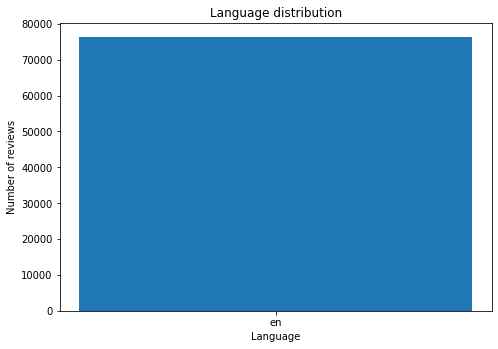

In [18]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = df['LANGUAGE'].value_counts().index
y = df['LANGUAGE'].value_counts()
ax.bar(x,y)
plt.xlabel('Language')
plt.ylabel('Number of reviews')
plt.title(f'Language distribution')
plt.rcParams['figure.facecolor'] = 'white'
plt.show()
fig.savefig("../Figures/schema_movie_lang_dist.png")

In [12]:
df = df[df['LANGUAGE'] == "en"]
print("After removing non-english text:", len(df))

After removing non-english text: 76442


In [13]:
# ADJUSTING THE RATING VALUES
df['REVIEWRATING'].value_counts().index.tolist()
# df['BESTRATING'].value_counts().index.tolist()
# df['WORSTRATING'].value_counts().index.tolist()

def chForm(value):
    value = re.sub(r'[a-zA-Z]|@|%| |"|-|\\', '', value)
    # return value
    if value != "":
        value = float(value)
    else:
        value = float(0)
    return round(value)
df['REVIEWRATING_new'] = df.apply(lambda row: chForm(row['REVIEWRATING']), axis=1)
df['BESTRATING_new']= df.apply(lambda row: chForm(row['BESTRATING']), axis=1)
df['WORSTRATING_new']= df.apply(lambda row: chForm(row['WORSTRATING']), axis=1)

In [14]:
df['REVIEWRATING_new'].value_counts().index.tolist()
# df['BESTRATING_new'].value_counts().index.tolist()
# df['WORSTRATING_new'].value_counts().index.tolist()

[4,
 3,
 2,
 1,
 10,
 5,
 7,
 8,
 6,
 39,
 9,
 59,
 49,
 29,
 19,
 69,
 79,
 0,
 89,
 99,
 44,
 54,
 20,
 64,
 33,
 34,
 70,
 45,
 55,
 50,
 58,
 42,
 24,
 30,
 74,
 40]

In [15]:
df['REVIEWRATING_new'].value_counts()


4     11112
3      9912
2      9071
1      4993
10     4948
5      4415
7      4186
8      4178
6      4120
39     3631
9      2996
59     2986
49     2649
29     1907
19     1890
69     1635
79      995
0       567
89      143
99       40
44       34
54       13
20        3
64        3
33        2
34        2
70        2
45        1
55        1
50        1
58        1
42        1
24        1
30        1
74        1
40        1
Name: REVIEWRATING_new, dtype: int64

In [16]:
def adjust_rating(n, range1, range2):
    try:
        if n > range1[1]:
            return range2[1]
        delta1 = range1[1] - range1[0]
        delta2 = range2[1] - range2[0]
        result =  (round(delta2 * (n - range1[0]) / delta1) + range2[0])
        if result == 0:
            result = 1
        return result
    except ZeroDivisionError:
        if range1 == [5,5]:
            return  5

df['REVIEWRATING_adj'] = df.apply(lambda row: adjust_rating(row['REVIEWRATING_new'], [row['WORSTRATING_new'],row['BESTRATING_new']], [1.0,5.0]), axis=1)

In [17]:
print(df['REVIEWRATING_adj'].value_counts(normalize=True))
print(df['REVIEWRATING_adj'].value_counts())

3.0    0.349821
4.0    0.243884
5.0    0.164818
2.0    0.151540
1.0    0.089937
Name: REVIEWRATING_adj, dtype: float64
3.0    26741
4.0    18643
5.0    12599
2.0    11584
1.0     6875
Name: REVIEWRATING_adj, dtype: int64


In [29]:
df.head()

,NODE,URL,REVIEWBODY,RATING,REVIEWRATING,BESTRATING,WORSTRATING,mis_rat,LANGUAGE,REVIEWRATING_new,BESTRATING_new,WORSTRATING_new,REVIEWRATING_adj
56,_:node67cd24b82f6aac54159a4a3da5cbc61,https://www.proporta.com/gripstick-dashboard-m...,"""Got this for my girl friend as she always use...",_:node7d38cd7abc6750c81e2c72e826158f91,"""5""@en","""5""@en","""1""@en",True,en,5,5,1,5.0
184,_:node126aab50111c8baa2a9b428b9bd38,https://www.criticreviewer.com/product-detail/...,"""Huawei Nova 3i in the price range comes with ...",_:node741942594d369a5cd03afb4015afdec4,"""4.5""@en-US","""5""@en-US","""0""@en-US",True,en,4,5,0,4.0
468,_:node9a9f5786e19fc599e1f1e2f772a1479,https://www.techadvisor.co.uk/review/mid-range...,"""A larger version of the company's flagship Mi...",_:node5cee9fd6acf86f20d1ac778fdbbc3fe3,"""9""","""10""","""1""",True,en,9,10,1,5.0
509,_:node9f62bb7b6b6e5e87f57becd1fec4158,https://www.techadvisor.co.uk/review/high-end-...,"""As expected, HTC is back with some new smartp...",_:nodef3a2f340f990be60e236bed2a1d74a70,"""8""","""10""","""1""",True,en,8,10,1,4.0
588,_:node37789de78cfaa6db6aa5c8991579e443,https://www.techadvisor.co.uk/review/android-s...,"""Samsung has updated it\u2019s A series phones...",_:nodee28bf0f0baa525ab1a86ddb7205e4fe5,"""7""","""10""","""1""",True,en,7,10,1,4.0


In [30]:
df.describe()

,REVIEWRATING_new,BESTRATING_new,WORSTRATING_new,REVIEWRATING_adj
count,22566.000000,22566.000000,22566.000000,22566.000000
mean,8.031419,9.181867,0.765444,4.658557
std,15.866389,18.944276,0.427375,0.706156
min,0.000000,1.000000,0.000000,1.000000
25%,5.000000,5.000000,1.000000,5.000000
50%,5.000000,5.000000,1.000000,5.000000
75%,5.000000,5.000000,1.000000,5.000000
max,100.000000,100.000000,6.000000,5.000000


In [31]:
df.to_csv('../Data/movie_reviews.csv')

In [ ]:
# finding out where the reviews come from (domain specific)
# def getNetloc(row):
#     try:
#         return urlparse(row['URL']).netloc
#     except:
#         print("expection: ", row['URL'])
#     else:
#         print("sad", row['URL'])
#
# df['netloc'] = df.apply(getNetloc, axis = 1)
# df.head()
# df['netloc'].value_counts().index.to_list()
# phone_lst = ['smartphone', 'phone',
#              'phone case', 'phone cable', 'phone charger', 'phone mount',
#              'cell phone', 'mobile phone']
#
#
# # df_phone = df_en[df_en['REVIEWBODY'].isin(phone_lst)]
# # print(df_phone.head())
# # LANGUAGE'] == "en"]
# df_en.head()

In [ ]:
print("ACTION: drop rows where any of the values is null or invalid")

# df = df[~df['REVIEWRATING'].str.contains("editorReview.rating")]
# df = df[~df['REVIEWRATING'].str.contains("missing value")]
df = df[~df['URL'].str.contains("johnpacker")]
df = df[~df['URL'].str.contains("dougshop")]
print(df.describe())